# ANALISIS DE DATOS FUNCIONALES

### Base de Datos

Estudios clinicos de daibetes para diversos pacientes, se tomará la muestra de glucosa de 120 minutos

## Librerias Usadas

In [1]:
# Importación de bibliotecas necesarias para el manejo de datos y análisis estadístico
import skfda  # Scikit-FDA para análisis de datos funcionales
import pandas as pd  # Pandas para manipulación y análisis de datos
import numpy as np  # NumPy para operaciones matemáticas de alto rendimiento
import matplotlib.pyplot as plt  # Matplotlib para visualización de gráficos
from scipy.interpolate import make_interp_spline  # SciPy para interpolación spline

# Importación de herramientas para serialización de objetos en Python
import pickle  # Pickle para serializar y deserializar estructuras de objetos de Python

# Importaciones específicas de Scikit-FDA para visualización y análisis de datos funcionales
from skfda.exploratory.visualization import Boxplot  # Visualización de boxplots para datos funcionales
from skfda import FDataGrid  # Estructura de datos para grillas de datos funcionales
from skfda.preprocessing.dim_reduction.projection import FPCA  # Análisis de componentes principales funcional
from skfda.ml.clustering import KMeans  # K-Means para clustering de datos funcionales
from skfda.misc.metrics import LpDistance  # Métrica de distancia Lp para comparación de funciones

# Importaciones para evaluación de modelos de Machine Learning
from sklearn.metrics import confusion_matrix  # Matriz de confusión para evaluar la precisión de clasificación
import seaborn as sns  # Seaborn para visualización de datos estadísticos avanzados


C:\Users\nmari\AppData\Local\Temp\ipykernel_16368\917717712.py:14: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA  # Análisis de componentes principales funcional


## Preprocesamos los datos

In [ ]:
data = pd.read_excel('InsCOND.xlsx')
data = data.iloc[:-6]
data

In [4]:
#Conocer exactamente el nombre con el que estan definidas nuestras condiciones medicas de cada paciente, notemos que en Prediabetes existe un espacio
condiciones_medicas = data['COND'].unique()
condiciones_medicas


array(['Normal', 'Prediabetes ', 'Diabetes tipo 2'], dtype=object)

In [5]:
# Contar NaN en cada columna
nan_count = data.isna().sum()
# Mostrar el conteo de NaN por columna
print(nan_count)

Clave                             0
No.                               0
GENERO (0=M;1=f)                  0
Edad                              0
Gluc-0                            0
Gluc+30                          14
Gluc+60                          18
Gluc+90                          23
Gluc+120                         10
Gluc.aver.OGTT                    0
Ins.0                             2
Ins.30                           16
Ins.60                           23
Ins.90                           40
Ins.120                          36
Ins.aver                          0
Matsuda.index                     2
HOMA.index                        2
Insulinogenic.Index..DI.DG.       6
Disposition.Index...IGI.ISI.      6
Weight..kg.                     100
Height..m.                       99
BMI                             100
Cintura..cm.                    114
Grasa....                       123
PA.sist                         125
PA.diast                        126
HbA1c                       

In [ ]:
# Limpiar los datos eliminando filas con valores faltantes en las mediciones relevantes
columns_to_check = ['Gluc-0', 'Gluc+30', 'Gluc+60', 'Gluc+90', 'Gluc+120']
data_clean = data.dropna(subset=columns_to_check)
data_clean

In [8]:
# Crear un mapeo de las condiciones médicas a números
condition_mapping = {
    'Normal': 0,
    'Prediabetes ': 1,
    'Diabetes tipo 2': 2
}

# Aplicar el mapeo al DataFrame para crear una columna de etiquetas numéricas
data['CondicionNumerica'] = data['COND'].map(condition_mapping)


C:\Users\nmari\AppData\Local\Temp\ipykernel_16368\2911869730.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CondicionNumerica'] = data['COND'].map(condition_mapping)


In [11]:
f = data['COND'].value_counts()
f

COND
Normal             911
Prediabetes        481
Diabetes tipo 2    104
Name: count, dtype: int64

In [12]:
# Conteo de frecuencias de cada categoría de BMI
bmi_counts = data['BMI Category'].value_counts()
bmi_counts = bmi_counts.reindex(['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese'])
print(bmi_counts)


BMI Category
Underweight          7.0
Normal             272.0
Overweight         551.0
Obese              568.0
Extremely Obese      NaN
Name: count, dtype: float64


## Experimentación de datos funcionales

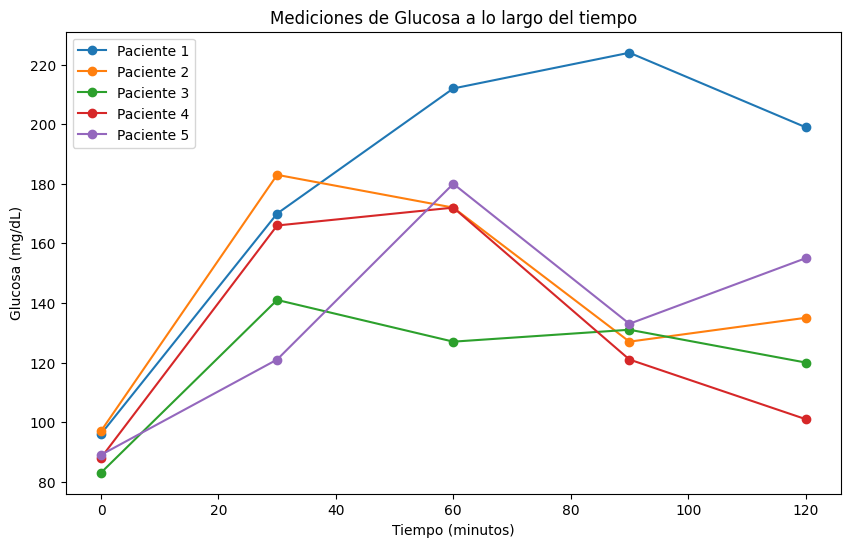

In [13]:
# Seleccionar solo algunas filas para visualizar
subset_data = data.head(5)

# Definir los tiempos de las mediciones
tiempos = [0, 30, 60, 90, 120]

# Graficar las mediciones de glucosa para los primeros 10 pacientes
plt.figure(figsize=(10, 6))
for index, row in subset_data.iterrows():
    plt.plot(tiempos, row[['Gluc-0', 'Gluc+30', 'Gluc+60', 'Gluc+90', 'Gluc+120']], marker='o', label=f'Paciente {index+1}')

plt.title('Mediciones de Glucosa a lo largo del tiempo')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
plt.legend()
plt.show()


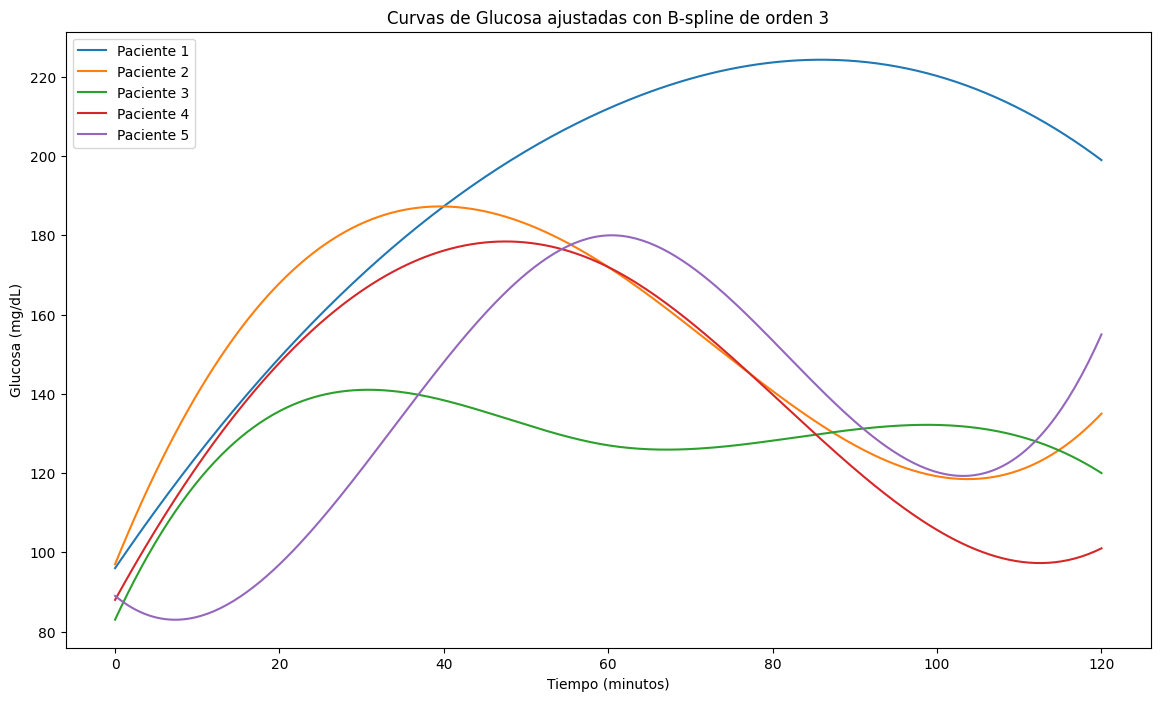

In [14]:
# Definir los tiempos de las mediciones
tiempos = np.array([0, 30, 60, 90, 120])
# Preparar una figura para múltiples plots
plt.figure(figsize=(14, 8))

# Ajustar y graficar un B-spline de orden 3 para cada paciente
for index, row in subset_data.iterrows():
    glucosa = row[['Gluc-0', 'Gluc+30', 'Gluc+60', 'Gluc+90', 'Gluc+120']].values
    # Crear el spline de orden 3
    spline = make_interp_spline(tiempos, glucosa, k=3)
    # Definir los puntos donde evaluaremos el spline
    tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)
    glucosa_spline = spline(tiempos_finos)
    
    # Graficar
    plt.plot(tiempos_finos, glucosa_spline, label=f'Paciente {index+1}')

plt.title('Curvas de Glucosa ajustadas con B-spline de orden 3')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
plt.legend()
plt.show()

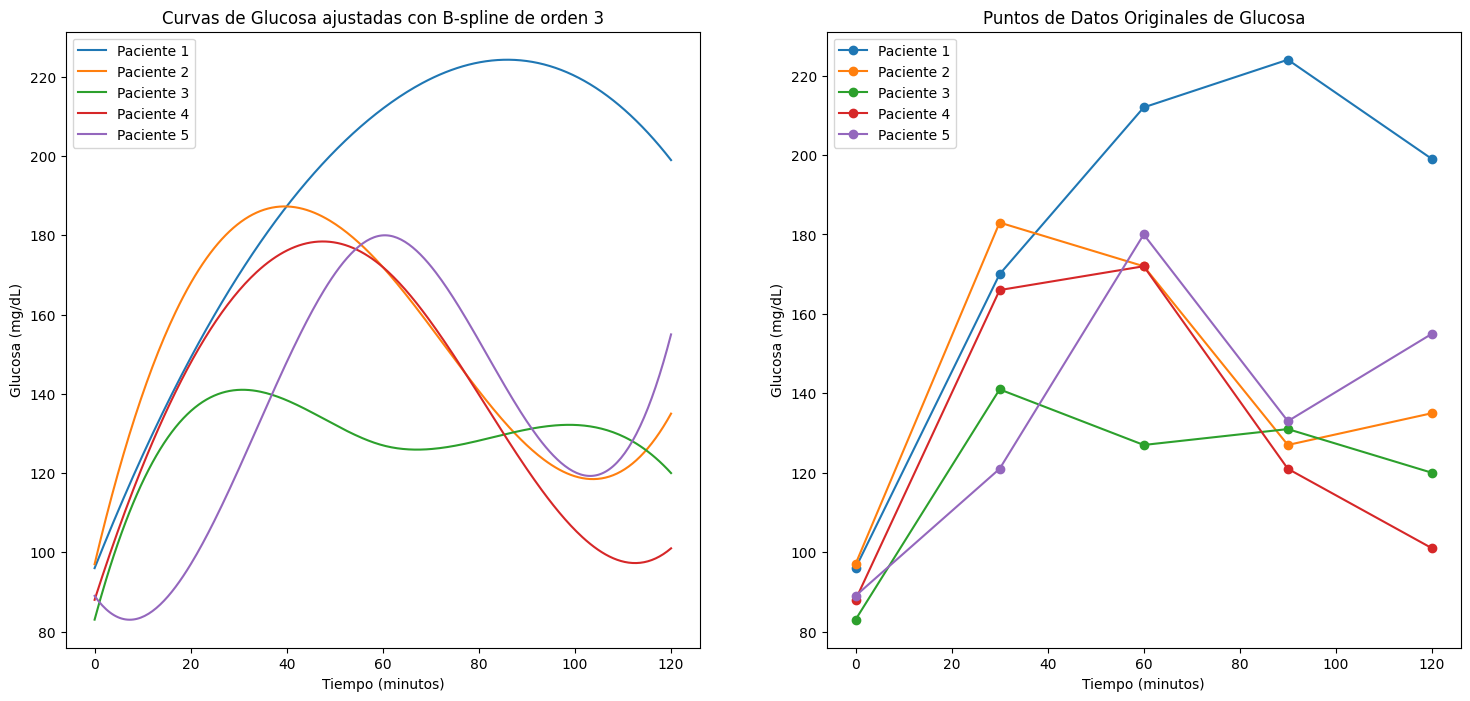

In [15]:
# Preparar la figura para comparar visualmente como se ve el B- Spline creado con respecto a los datos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Ajustar y graficar un B-spline de orden 3 para cada paciente
for index, row in subset_data.iterrows():
    glucosa = row[['Gluc-0', 'Gluc+30', 'Gluc+60', 'Gluc+90', 'Gluc+120']].values
    # Crear el spline de orden 3
    spline = make_interp_spline(tiempos, glucosa, k=3)
    # Definir los puntos donde evaluaremos el spline
    tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)
    glucosa_spline = spline(tiempos_finos)
    
    # Graficar las funciones ajustadas en el subplot de la izquierda
    ax1.plot(tiempos_finos, glucosa_spline, label=f'Paciente {index+1}')
    # Graficar los puntos originales en el subplot de la derecha
    ax2.plot(tiempos, glucosa, 'o-', label=f'Paciente {index+1}')

ax1.set_title('Curvas de Glucosa ajustadas con B-spline de orden 3')
ax1.set_xlabel('Tiempo (minutos)')
ax1.set_ylabel('Glucosa (mg/dL)')

ax2.set_title('Puntos de Datos Originales de Glucosa')
ax2.set_xlabel('Tiempo (minutos)')
ax2.set_ylabel('Glucosa (mg/dL)')

# Añadir leyendas a ambos subplots
ax1.legend()
ax2.legend()

plt.show()

## Aplicar B-Splines a todos los datos

Seleccionar columnas de interés

Se crean las funciones para todos los datos sin ninguna partición y se guarda en un archivo pkl

In [18]:
splines = []
for index, row in glucosa.iterrows():
    glucosa = row[['Gluc-0', 'Gluc+30', 'Gluc+60', 'Gluc+90', 'Gluc+120']].values
    spline = make_interp_spline(tiempos, glucosa, k=3)
    splines.append(spline)

# Guardar los objetos spline
with open('splines.pkl', 'wb') as f:
    pickle.dump(splines, f)

Se visualizan

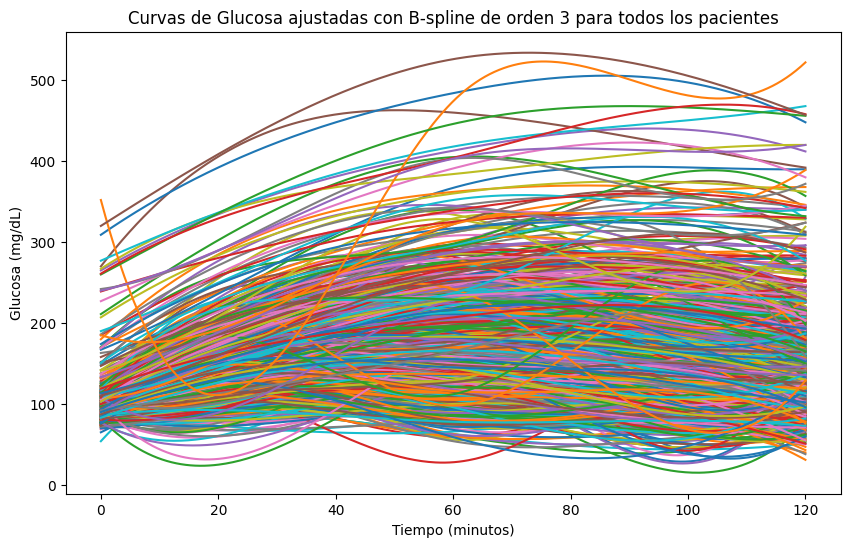

In [19]:
# Cargar los objetos spline
with open('splines.pkl', 'rb') as f:
    splines = pickle.load(f)

# Visualizar
tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)
plt.figure(figsize=(10, 6))
for spline in splines:
    glucosa_spline = spline(tiempos_finos)
    plt.plot(tiempos_finos, glucosa_spline)
plt.title('Curvas de Glucosa ajustadas con B-spline de orden 3 para todos los pacientes')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
plt.show()


## B - SPLINES POR  GENERO

Ahora se hace una primera partición, suponiendo que existen diferentes tendencias en mujeres que en hombres

In [20]:
columnas_glucosa = ['Gluc-0', 'Gluc+30', 'Gluc+60', 'Gluc+90', 'Gluc+120']
columnas_interes = columnas_glucosa + ['GENERO (0=M;1=f)']
data_interes = data[columnas_interes]

# Separar los datos por género
data_hombres = data_interes[data_interes['GENERO (0=M;1=f)'] == 0].drop(columns=['GENERO (0=M;1=f)'])
data_mujeres = data_interes[data_interes['GENERO (0=M;1=f)'] == 1].drop(columns=['GENERO (0=M;1=f)'])
data_hombres = data_hombres.dropna()
data_mujeres = data_mujeres.dropna()

Se realizan los Splines para Hombres y mujeres y se guardan en archivos pkl

In [23]:
# Asumiendo que data_hombres ya está definido y cargado
splines_hombres = []
tiempos = np.array([0, 30, 60, 90, 120])  

for index, row in data_hombres.iterrows():
    glucosa = row[['Gluc-0', 'Gluc+30', 'Gluc+60', 'Gluc+90', 'Gluc+120']].values
    spline = make_interp_spline(tiempos, glucosa, k=3)
    splines_hombres.append(spline)

# Guardar los objetos spline
with open('splines_hombres.pkl', 'wb') as f:
    pickle.dump(splines_hombres, f)


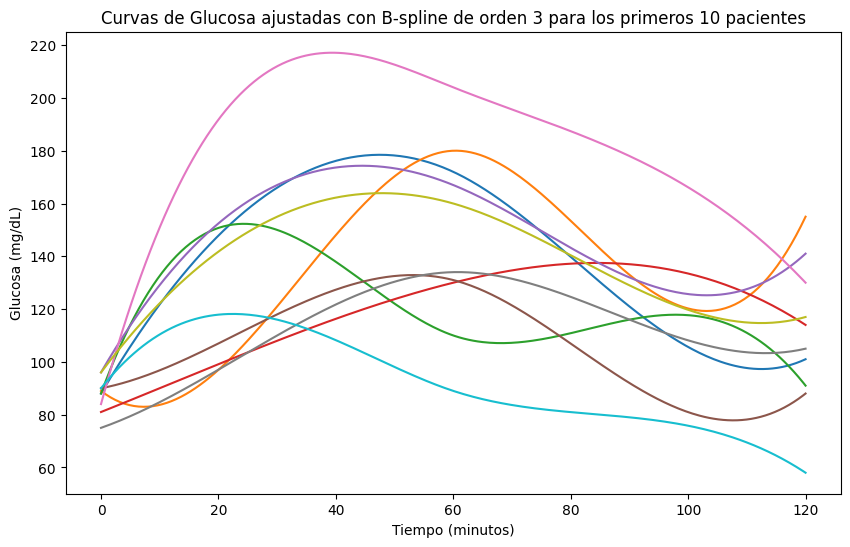

In [24]:
# Cargar los objetos spline
with open('splines_hombres.pkl', 'rb') as f:
    splines_hombres = pickle.load(f)
tiempos = np.array([0, 30, 60, 90, 120])

tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)

plt.figure(figsize=(10, 6))

# Graficar las curvas de los primeros 10 pacientes
for spline in splines_hombres[:10]:  
    glucosa_spline = spline(tiempos_finos)
    plt.plot(tiempos_finos, glucosa_spline)

plt.title('Curvas de Glucosa ajustadas con B-spline de orden 3 para los primeros 10 pacientes')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
plt.show()


In [25]:
# Crear una lista para guardar los splines
splines_mujeres = []

# Generar un spline para cada conjunto de mediciones de glucosa
for index, row in data_mujeres.iterrows():
    glucosa = row[['Gluc-0', 'Gluc+30', 'Gluc+60', 'Gluc+90', 'Gluc+120']].values
    spline = make_interp_spline(tiempos, glucosa, k=3)
    splines_mujeres.append(spline)

# Guardar los objetos spline en un archivo pickle
with open('splines_mujeres.pkl', 'wb') as f:
    pickle.dump(splines_mujeres, f)


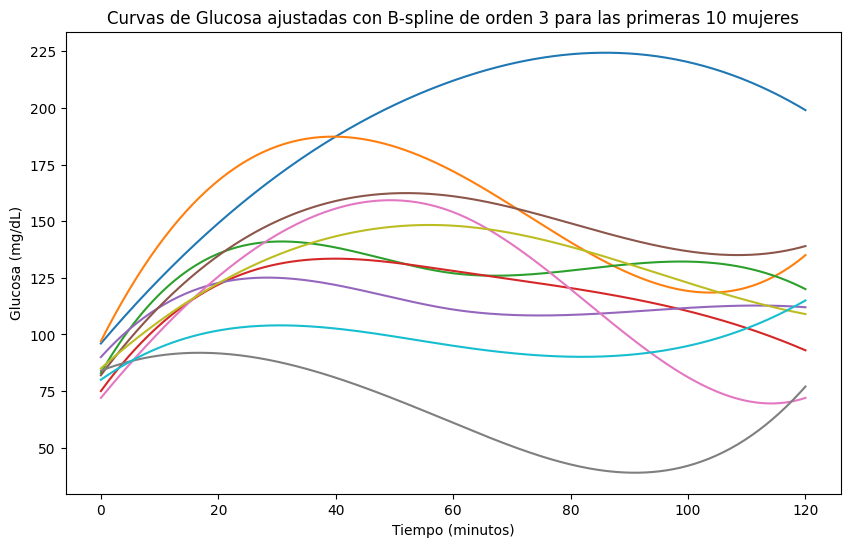

In [26]:
with open('splines_mujeres.pkl', 'rb') as f:
    splines_mujeres = pickle.load(f)

tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)

# Configurar la visualización
plt.figure(figsize=(10, 6))

# Graficar las curvas de los primeros 10 pacientes
for spline in splines_mujeres[:10]:  
    glucosa_spline = spline(tiempos_finos)
    plt.plot(tiempos_finos, glucosa_spline)

plt.title('Curvas de Glucosa ajustadas con B-spline de orden 3 para las primeras 10 mujeres')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
plt.show()


## B- SPLINES POR CONDICION MÉDICA

In [27]:
columnas_glucosa = ['Gluc-0', 'Gluc+30', 'Gluc+60', 'Gluc+90', 'Gluc+120']
columnas_interes = columnas_glucosa + ['COND']

# Seleccionar solo las columnas de interés
data_interes_2 = data[columnas_interes]

In [28]:
# Separar los datos por condición médica
data_normal = data_interes_2[data_interes_2['COND'] == 'Normal']
data_prediabetes = data_interes_2[data_interes_2['COND'] == 'Prediabetes ']
data_tipo2 = data_interes_2[data_interes_2['COND'] == 'Diabetes tipo 2']

SLPLINES NORMAL

In [30]:
splines_normal = []
tiempos = np.array([0, 30, 60, 90, 120])  

for index, row in data_normal.iterrows():
    glucosa = row[['Gluc-0', 'Gluc+30', 'Gluc+60', 'Gluc+90', 'Gluc+120']].values
    spline = make_interp_spline(tiempos, glucosa, k=3)
    splines_normal.append(spline)

# Guardar los objetos spline
with open('splines_normal.pkl', 'wb') as f:
    pickle.dump(splines_normal, f)  # Corregido aquí para usar splines_hombres


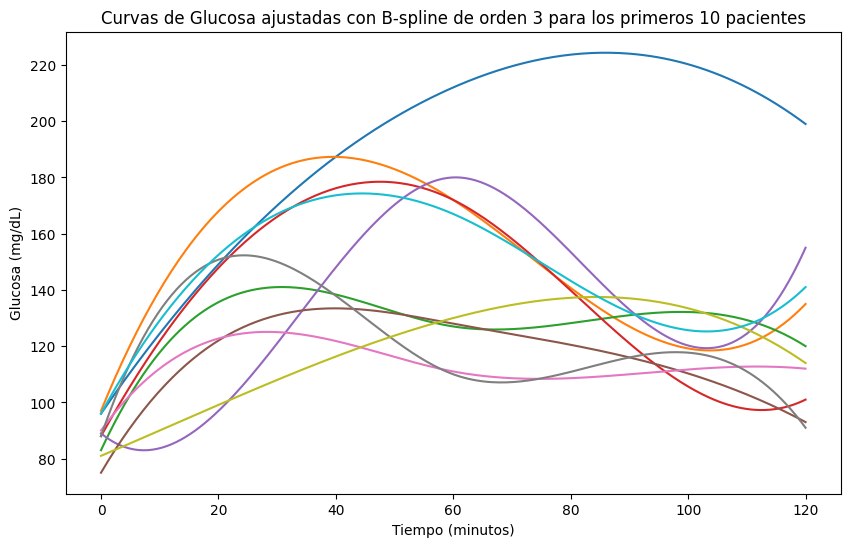

In [31]:
# Cargar los objetos spline
with open('splines_normal.pkl', 'rb') as f:
    splines_normal = pickle.load(f)
tiempos = np.array([0, 30, 60, 90, 120])

tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)

plt.figure(figsize=(10, 6))

# Graficar las curvas de los primeros 10 pacientes
for spline in splines_normal[:10]:  
    glucosa_spline = spline(tiempos_finos)
    plt.plot(tiempos_finos, glucosa_spline)

plt.title('Curvas de Glucosa ajustadas con B-spline de orden 3 para los primeros 10 pacientes')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
plt.show()


PREDIABETES

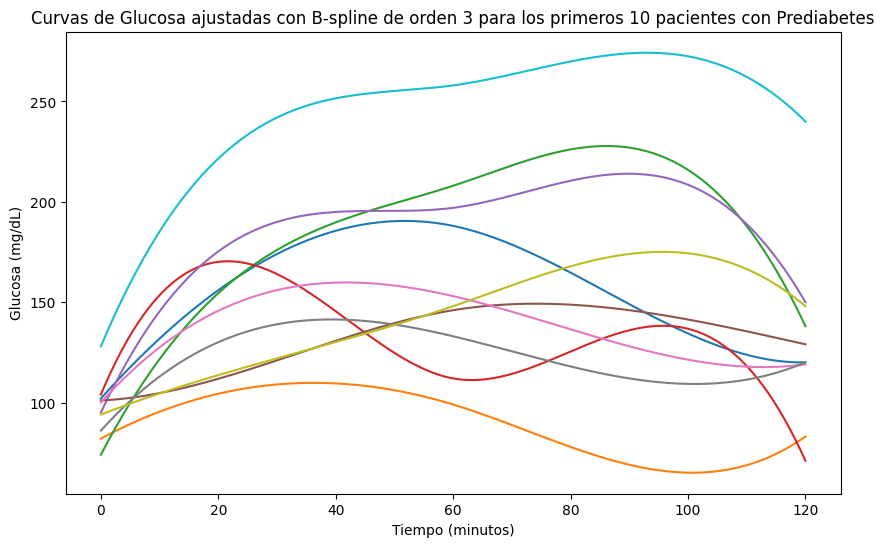

In [32]:
splines_prediabetes = []

for index, row in data_prediabetes.iterrows():
    glucosa = row[columnas_glucosa].values
    spline = make_interp_spline(tiempos, glucosa, k=3)
    splines_prediabetes.append(spline)

# Guardar los objetos spline en un archivo .pkl
with open('splines_prediabetes.pkl', 'wb') as f:
    pickle.dump(splines_prediabetes, f)

# Cargar los objetos spline del archivo .pkl
with open('splines_prediabetes.pkl', 'rb') as f:
    splines_prediabetes = pickle.load(f)

# Generar tiempos finos para interpolación
tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)

# Graficar las curvas de los primeros 10 pacientes
plt.figure(figsize=(10, 6))
for spline in splines_prediabetes[:10]:  
    glucosa_spline = spline(tiempos_finos)
    plt.plot(tiempos_finos, glucosa_spline)

plt.title('Curvas de Glucosa ajustadas con B-spline de orden 3 para los primeros 10 pacientes con Prediabetes')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
plt.show()


 DIABETES TIPO 2

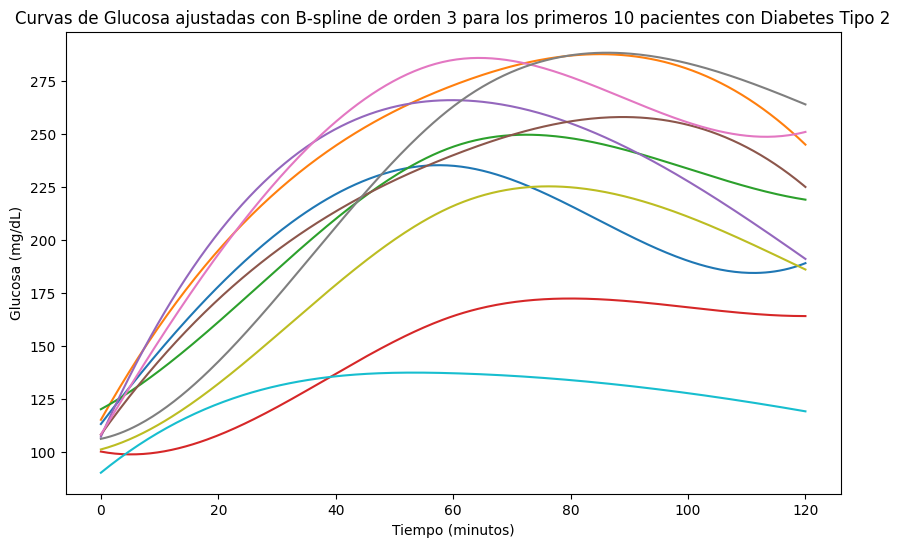

In [33]:
splines_tipo2 = []
for index, row in data_tipo2.iterrows():
    glucosa = row[columnas_glucosa].values
    spline = make_interp_spline(tiempos, glucosa, k=3)
    splines_tipo2.append(spline)
with open('splines_tipo2.pkl', 'wb') as f:
    pickle.dump(splines_tipo2, f)
with open('splines_tipo2.pkl', 'rb') as f:
    splines_tipo2 = pickle.load(f)

tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)

# Graficar las curvas de los primeros 10 pacientes
plt.figure(figsize=(10, 6))
for spline in splines_tipo2[:10]:  
    glucosa_spline = spline(tiempos_finos)
    plt.plot(tiempos_finos, glucosa_spline)

plt.title('Curvas de Glucosa ajustadas con B-spline de orden 3 para los primeros 10 pacientes con Diabetes Tipo 2')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
plt.show()


## ANALISIS DE CATEGORIAS DE BMI

In [34]:
color_map = {
    'Underweight': 'blue',
    'Normal': 'green',
    'Overweight': 'orange',
    'Obese': 'red',
}

HOMBRES

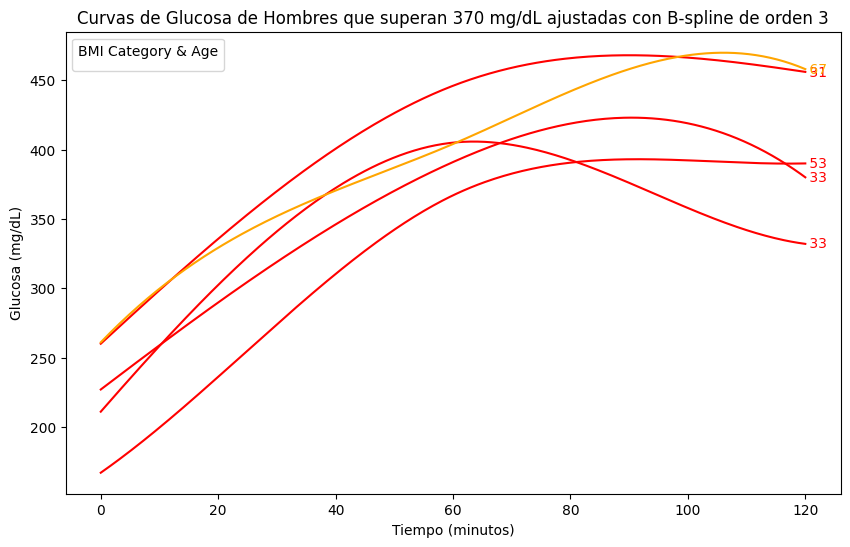

In [35]:
# Cargar los objetos spline
with open('splines_hombres.pkl', 'rb') as f:
    splines_hombres = pickle.load(f)

# Filtrar para obtener solo datos de hombres
data_hombres = data[data['GENERO (0=M;1=f)'] == 0]

# Asumimos que tienes una lista de categorías de BMI para hombres que corresponden a estos splines
bmi_categories = data_hombres['BMI Category'].head(len(splines_hombres))
ages = data_hombres['Edad'].head(len(splines_hombres))  # Asegurarse de tener la edad

tiempos = np.array([0, 30, 60, 90, 120])
tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)

plt.figure(figsize=(10, 6))

# Mapa de colores para las categorías de BMI
color_map = {
    'Underweight': 'blue',
    'Normal': 'green',
    'Overweight': 'orange',
    'Obese': 'red',
}

# Graficar las curvas de los pacientes hombres que superen 300 mg/dL
for idx, spline in enumerate(splines_hombres):
    glucosa_spline = spline(tiempos_finos)
    # Filtrar para graficar solo las curvas que superan 300 mg/dL en algún momento
    if np.any(glucosa_spline > 370):
        color = color_map.get(bmi_categories.iloc[idx], 'black')  # Usar el color correspondiente de la categoría BMI
        label = f'{bmi_categories.iloc[idx]} ({ages.iloc[idx]} años)' if idx == 0 else ""
        plt.plot(tiempos_finos, glucosa_spline, color=color, label=label)
        plt.text(tiempos_finos[-1], glucosa_spline[-1], f' {ages.iloc[idx]}', verticalalignment='center', color=color)

plt.title('Curvas de Glucosa de Hombres que superan 370 mg/dL ajustadas con B-spline de orden 3')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
# Configurar las leyendas para mostrar solo una vez cada categoría
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='BMI Category & Age')
plt.show()


MUJERES

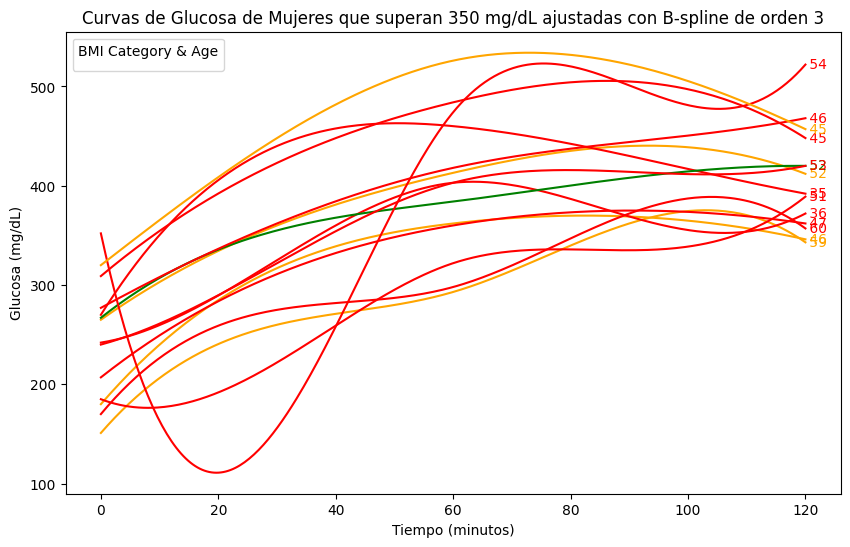

In [36]:
# Cargar los objetos spline para mujeres
with open('splines_mujeres.pkl', 'rb') as f:
    splines_mujeres = pickle.load(f)

# Filtrar para obtener solo datos de mujeres
data_mujeres = data[data['GENERO (0=M;1=f)'] == 1]

# Extraer las categorías de BMI y edades para estas pacientes
bmi_categories = data_mujeres['BMI Category'].head(len(splines_mujeres))
ages = data_mujeres['Edad'].head(len(splines_mujeres))

tiempos = np.array([0, 30, 60, 90, 120])
tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)

plt.figure(figsize=(10, 6))

# Mapa de colores para las categorías de BMI
color_map = {
    'Underweight': 'blue',
    'Normal': 'green',
    'Overweight': 'orange',
    'Obese': 'red',
}

# Graficar las curvas de las pacientes mujeres que superen 300 mg/dL
for idx, spline in enumerate(splines_mujeres):
    glucosa_spline = spline(tiempos_finos)
    # Filtrar para graficar solo las curvas que superan 300 mg/dL en algún momento
    if np.any(glucosa_spline > 365):  # Ajusta este umbral según sea necesario
        color = color_map.get(bmi_categories.iloc[idx], 'black')  # Usar el color correspondiente de la categoría BMI
        label = f'{bmi_categories.iloc[idx]} ({ages.iloc[idx]} años)' if idx == 0 else ""
        plt.plot(tiempos_finos, glucosa_spline, color=color, label=label)
        plt.text(tiempos_finos[-1], glucosa_spline[-1], f' {ages.iloc[idx]}', verticalalignment='center', color=color)

plt.title('Curvas de Glucosa de Mujeres que superan 350 mg/dL ajustadas con B-spline de orden 3')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
# Configurar las leyendas para mostrar solo una vez cada categoría
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='BMI Category & Age')
plt.show()


ANALISIS A LOS DIABETICOS TIPO 2

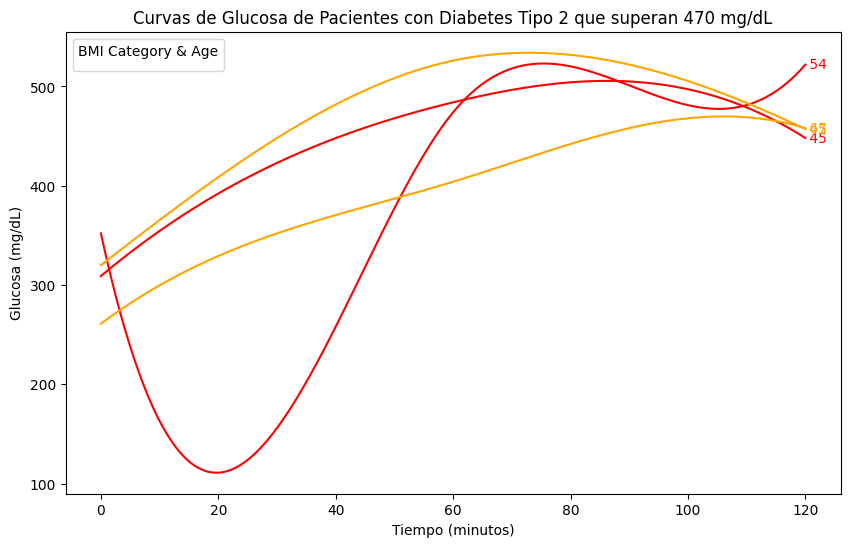

In [37]:
# Cargar los objetos spline para pacientes con Diabetes Tipo 2
with open('splines_tipo2.pkl', 'rb') as f:
    splines_tipo2 = pickle.load(f)

# Filtrar para obtener solo datos de pacientes con Diabetes Tipo 2
data_tipo2 = data[data['COND'] == 'Diabetes tipo 2']

# Extraer las categorías de BMI y edades
bmi_categories = data_tipo2['BMI Category'].head(len(splines_tipo2))
ages = data_tipo2['Edad'].head(len(splines_tipo2))

tiempos = np.array([0, 30, 60, 90, 120])
tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)

plt.figure(figsize=(10, 6))

# Mapa de colores para las categorías de BMI
color_map = {
    'Underweight': 'blue',
    'Normal': 'green',
    'Overweight': 'orange',
    'Obese': 'red',
}

# Graficar las curvas de los pacientes con Diabetes Tipo 2 que superen 300 mg/dL
for idx, spline in enumerate(splines_tipo2):
    glucosa_spline = spline(tiempos_finos)
    if np.any(glucosa_spline > 468):
        color = color_map.get(bmi_categories.iloc[idx], 'black')  # Usar el color correspondiente de la categoría BMI
        label = f'{bmi_categories.iloc[idx]} ({ages.iloc[idx]} años)' if idx == 0 else ""
        plt.plot(tiempos_finos, glucosa_spline, color=color, label=label)
        plt.text(tiempos_finos[-1], glucosa_spline[-1], f' {ages.iloc[idx]}', verticalalignment='center', color=color)

plt.title('Curvas de Glucosa de Pacientes con Diabetes Tipo 2 que superan 470 mg/dL')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
# Configurar las leyendas para mostrar solo una vez cada categoría
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='BMI Category & Age')
plt.show()


## BOXPLOT GENERO

Text(0, 0.5, 'Glucosa (mg/dL)')

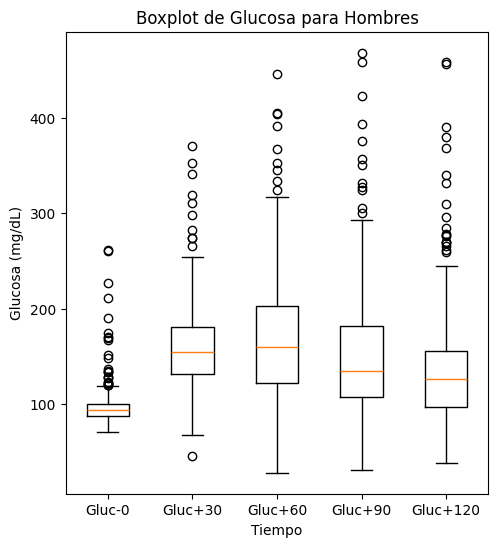

In [38]:
# Crear boxplots para hombres
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot([data_hombres[col] for col in columnas_glucosa], labels=columnas_glucosa)
plt.title('Boxplot de Glucosa para Hombres')
plt.xlabel('Tiempo')
plt.ylabel('Glucosa (mg/dL)')

Text(0, 0.5, 'Glucosa (mg/dL)')

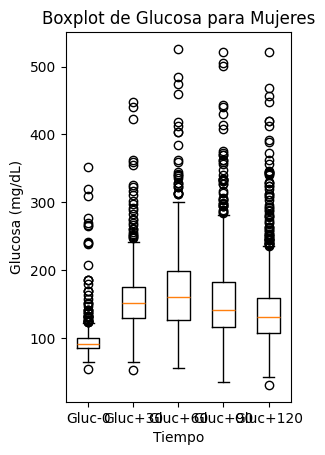

In [39]:
# Crear boxplots para mujeres
plt.subplot(1, 2, 2)
plt.boxplot([data_mujeres[col] for col in columnas_glucosa], labels=columnas_glucosa)
plt.title('Boxplot de Glucosa para Mujeres')
plt.xlabel('Tiempo')
plt.ylabel('Glucosa (mg/dL)')

In [40]:
# Definir los tiempos de medición
tiempos = np.array([0, 30, 60, 90, 120])

# Evaluar los splines en puntos finos
tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)
glucosa_hombres = np.array([spline(tiempos_finos) for spline in splines_hombres])
glucosa_mujeres = np.array([spline(tiempos_finos) for spline in splines_mujeres])

# Crear objetos FDataGrid
fd_hombres = skfda.FDataGrid(data_matrix=glucosa_hombres, grid_points=tiempos_finos)
fd_mujeres = skfda.FDataGrid(data_matrix=glucosa_mujeres, grid_points=tiempos_finos)

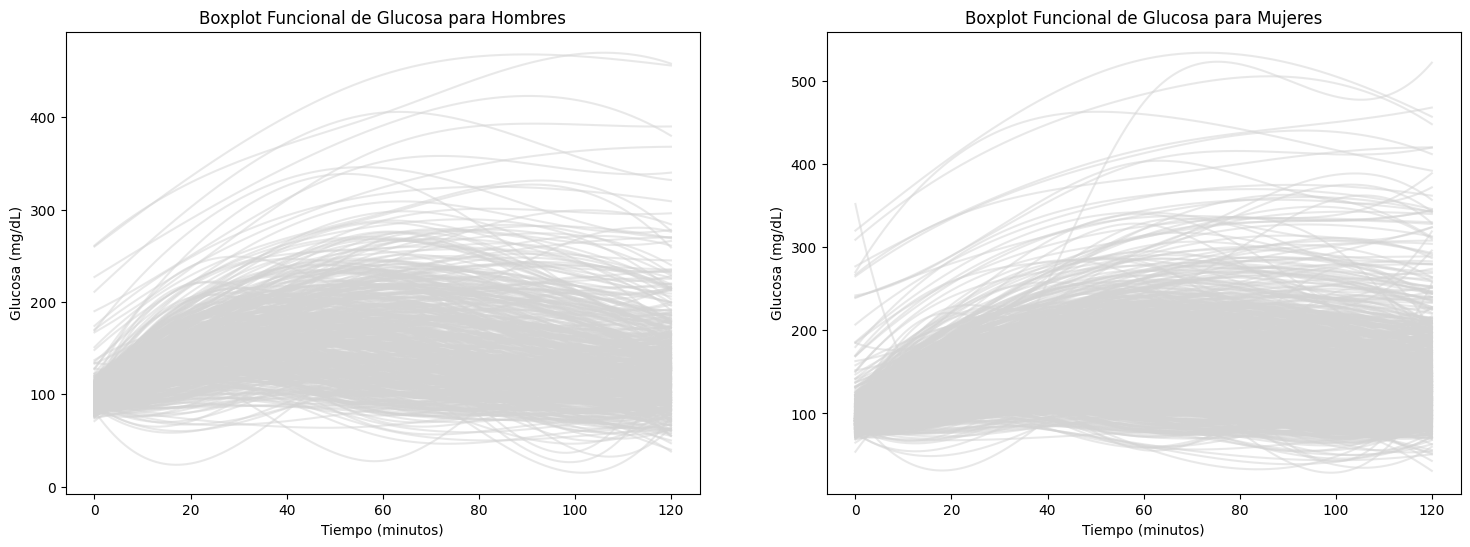

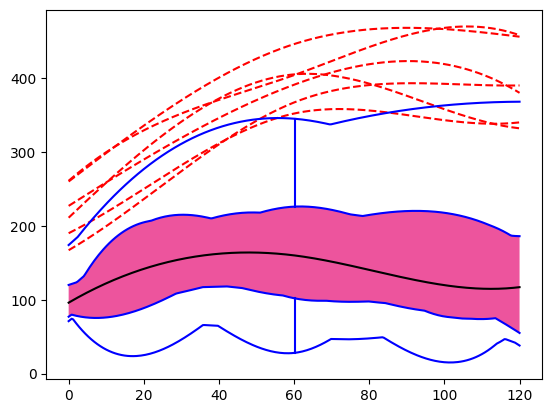

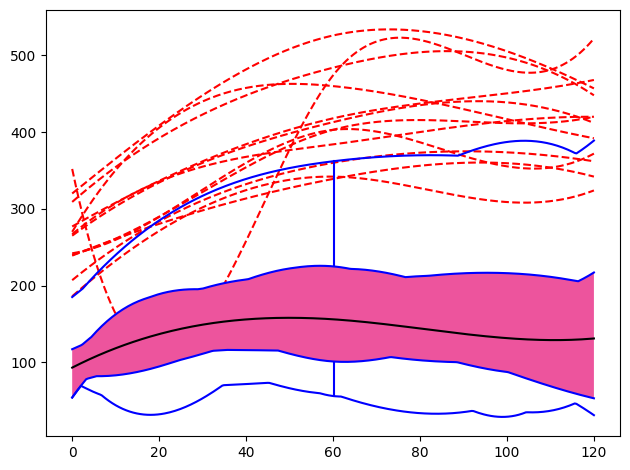

In [41]:
# Crear boxplots funcionales
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot para hombres
boxplot_hombres = Boxplot(fd_hombres)
boxplot_hombres.plot()
axes[0].plot(tiempos_finos, glucosa_hombres.T, color='lightgray', alpha=0.5)
axes[0].set_title('Boxplot Funcional de Glucosa para Hombres')
axes[0].set_xlabel('Tiempo (minutos)')
axes[0].set_ylabel('Glucosa (mg/dL)')

# Boxplot para mujeres
boxplot_mujeres = Boxplot(fd_mujeres)
boxplot_mujeres.plot()
axes[1].plot(tiempos_finos, glucosa_mujeres.T, color='lightgray', alpha=0.5)
axes[1].set_title('Boxplot Funcional de Glucosa para Mujeres')
axes[1].set_xlabel('Tiempo (minutos)')
axes[1].set_ylabel('Glucosa (mg/dL)')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

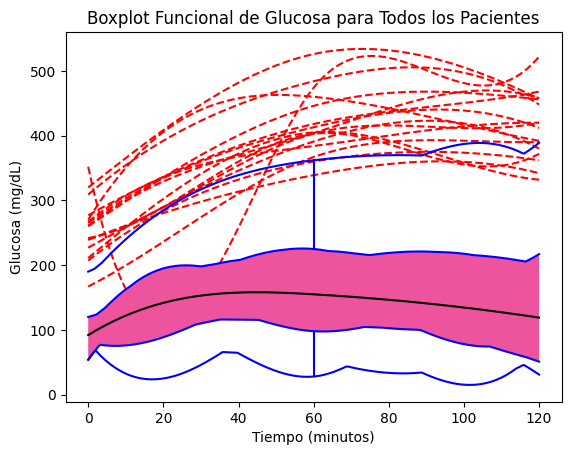

In [42]:
# Definir los tiempos de medición
tiempos = np.array([0, 30, 60, 90, 120])

# Evaluar los splines en puntos finos
tiempos_finos = np.linspace(tiempos.min(), tiempos.max(), 300)
glucosa_todos = np.array([spline(tiempos_finos) for spline in splines])

# Crear el objeto FDataGrid
fd_todos = skfda.FDataGrid(data_matrix=glucosa_todos, grid_points=tiempos_finos)

# Crear y visualizar el boxplot funcional
plt.figure(figsize=(12, 6))
boxplot_todos = Boxplot(fd_todos)
boxplot_todos.plot()
plt.title('Boxplot Funcional de Glucosa para Todos los Pacientes')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
plt.show()


### COMPARACIÓN


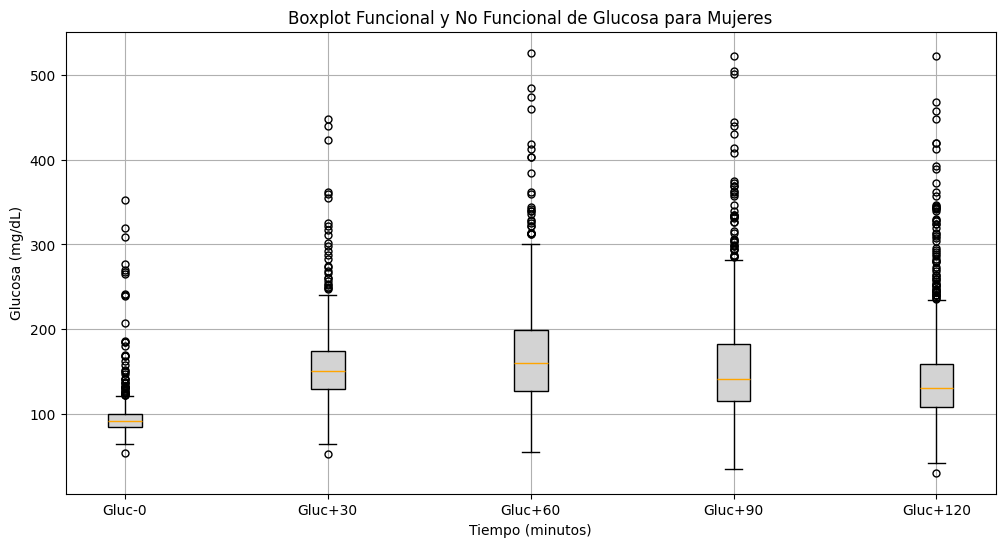

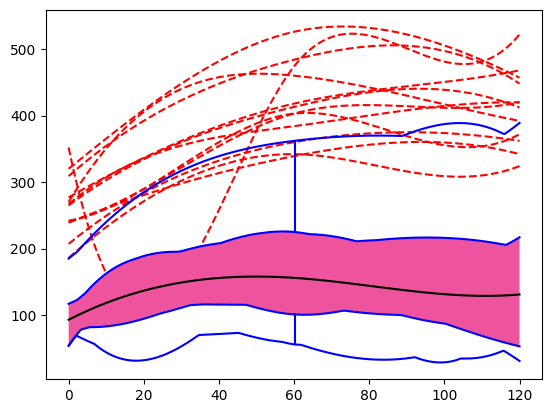

In [43]:
# Crear y visualizar los boxplots sobrepuestos
fig, ax = plt.subplots(figsize=(12, 6))

# Boxplots no funcionales
data_mujeres.boxplot(column=columnas_glucosa, ax=ax, positions=tiempos, widths=5, patch_artist=True,
                     boxprops=dict(facecolor='lightgray', color='black'),
                     medianprops=dict(color='orange'),
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'),
                     flierprops=dict(marker='o', color='black', markersize=5))

# Boxplot funcional
boxplot_mujeres = Boxplot(fd_mujeres)
boxplot_mujeres.plot()

ax.set_title('Boxplot Funcional y No Funcional de Glucosa para Mujeres')
ax.set_xlabel('Tiempo (minutos)')
ax.set_ylabel('Glucosa (mg/dL)')

plt.show()

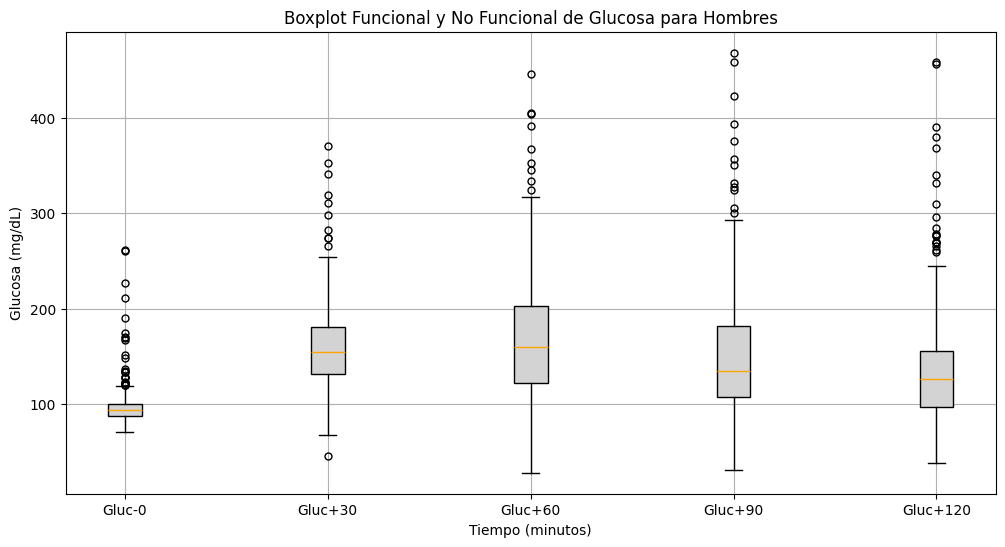

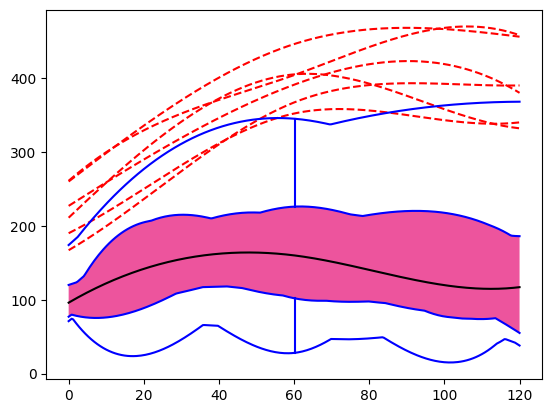

In [44]:
# Crear y visualizar los boxplots sobrepuestos
fig, ax = plt.subplots(figsize=(12, 6))

# Boxplots no funcionales
data_hombres.boxplot(column=columnas_glucosa, ax=ax, positions=tiempos, widths=5, patch_artist=True,
                     boxprops=dict(facecolor='lightgray', color='black'),
                     medianprops=dict(color='orange'),
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'),
                     flierprops=dict(marker='o', color='black', markersize=5))

# Boxplot funcional
boxplot_hombres = Boxplot(fd_hombres)
boxplot_hombres.plot()

ax.set_title('Boxplot Funcional y No Funcional de Glucosa para Hombres')
ax.set_xlabel('Tiempo (minutos)')
ax.set_ylabel('Glucosa (mg/dL)')

plt.show()

## BOXPLOT CONDICION MEDICA

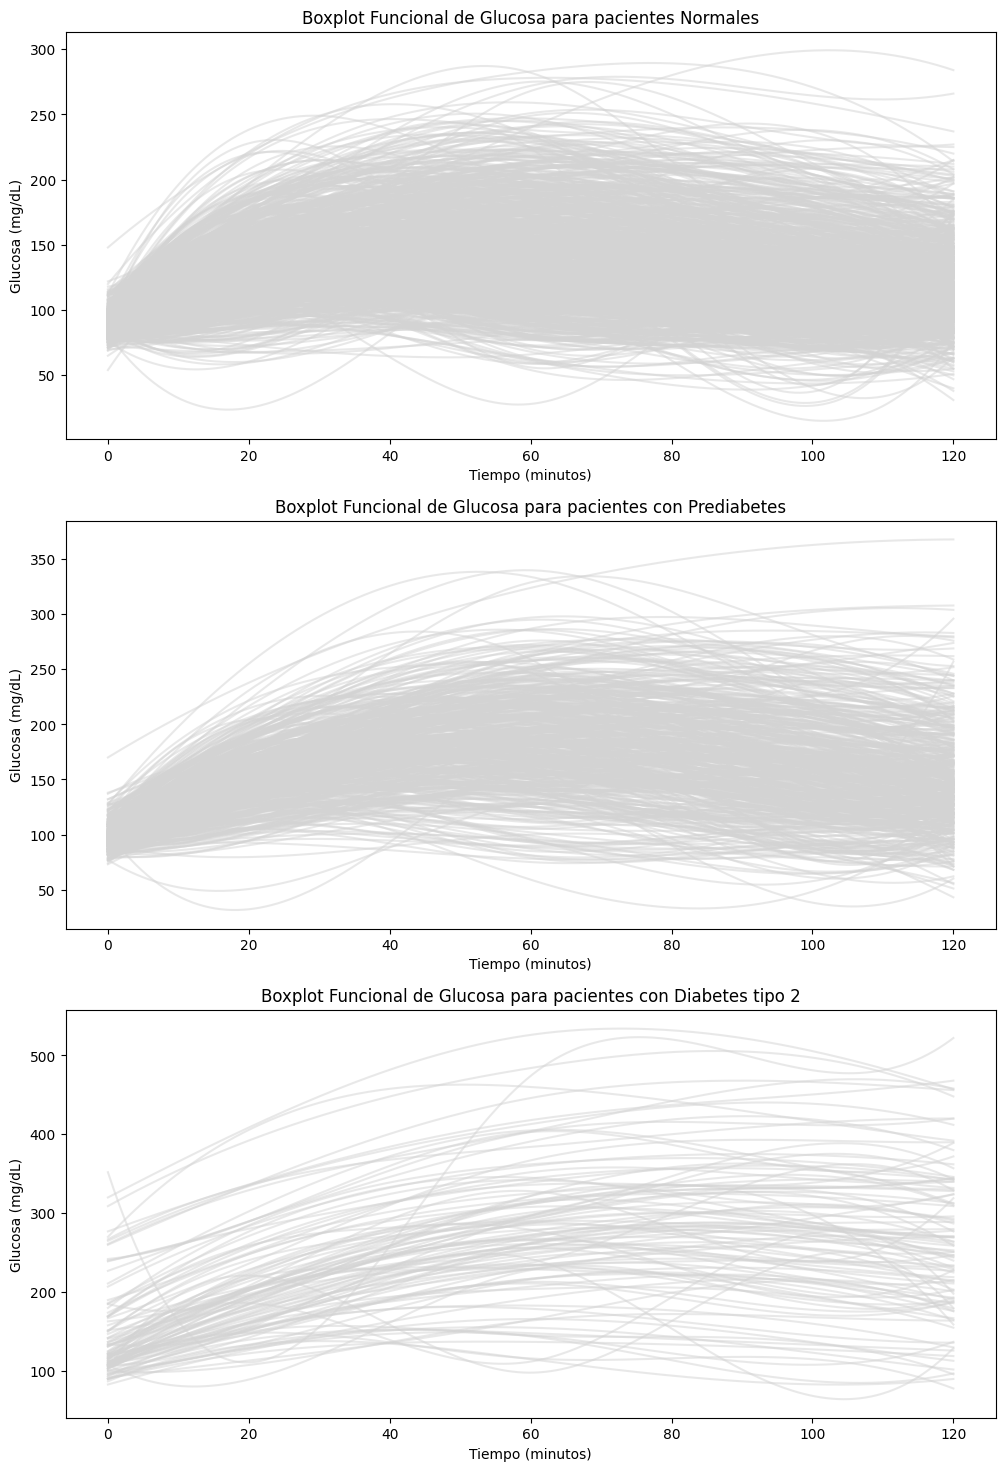

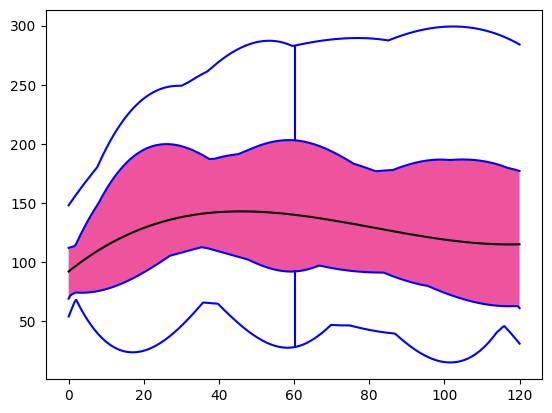

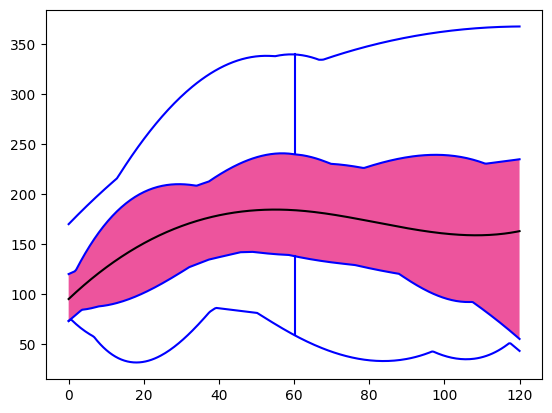

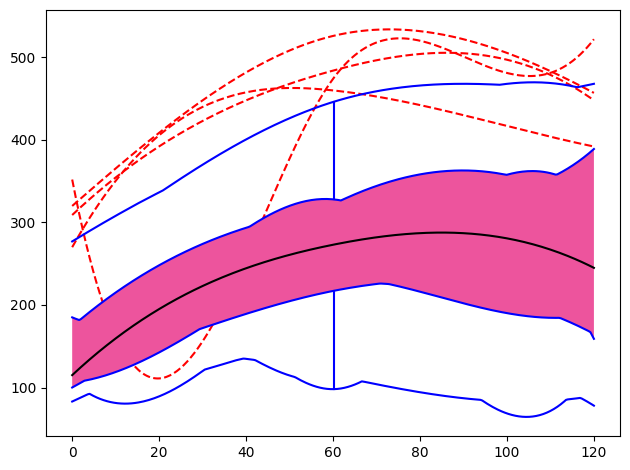

In [45]:
def generar_valores_interpolados(splines):
    valores_interpolados = []
    for spline in splines:
        glucosa_spline = spline(tiempos_finos)
        valores_interpolados.append(glucosa_spline)
    return np.array(valores_interpolados)

# Generar valores interpolados para cada condición
valores_normal = generar_valores_interpolados(splines_normal)
valores_prediabetes = generar_valores_interpolados(splines_prediabetes)
valores_tipo2 = generar_valores_interpolados(splines_tipo2)

fd_normal = skfda.FDataGrid(data_matrix=valores_normal, grid_points=tiempos_finos)
fd_prediabetes = skfda.FDataGrid(data_matrix=valores_prediabetes, grid_points=tiempos_finos)
fd_tipo2 = skfda.FDataGrid(data_matrix=valores_tipo2, grid_points=tiempos_finos)

# Crear boxplots funcionales
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Boxplot para 'Normal'
boxplot_normal = Boxplot(fd_normal)
boxplot_normal.plot()
axes[0].plot(tiempos_finos, valores_normal.T, color='lightgray', alpha=0.5)
axes[0].set_title('Boxplot Funcional de Glucosa para pacientes Normales')
axes[0].set_xlabel('Tiempo (minutos)')
axes[0].set_ylabel('Glucosa (mg/dL)')

# Boxplot para 'Prediabetes'
boxplot_prediabetes = Boxplot(fd_prediabetes)
boxplot_prediabetes.plot()
axes[1].plot(tiempos_finos, valores_prediabetes.T, color='lightgray', alpha=0.5)
axes[1].set_title('Boxplot Funcional de Glucosa para pacientes con Prediabetes')
axes[1].set_xlabel('Tiempo (minutos)')
axes[1].set_ylabel('Glucosa (mg/dL)')

# Boxplot para 'Diabetes tipo 2'
boxplot_tipo2 = Boxplot(fd_tipo2)
boxplot_tipo2.plot()
axes[2].plot(tiempos_finos, valores_tipo2.T, color='lightgray', alpha=0.5)
axes[2].set_title('Boxplot Funcional de Glucosa para pacientes con Diabetes tipo 2')
axes[2].set_xlabel('Tiempo (minutos)')
axes[2].set_ylabel('Glucosa (mg/dL)')

plt.tight_layout()
plt.show()


## PCA

In [46]:
# Supongamos que 'data_matrix' contiene tus datos de glucosa evaluados en 'tiempos_finos'
fd = FDataGrid(data_matrix=glucosa_todos, grid_points=tiempos_finos)

# Aplicar FPCA
fpca = FPCA(n_components=3)
fpca.fit(fd)
fd_transformed = fpca.transform(fd)
components = fpca.components_



Dimensiones de x: (300,), Dimensiones de y: (300,)
Dimensiones de x: (300,), Dimensiones de y: (300,)
Dimensiones de x: (300,), Dimensiones de y: (300,)


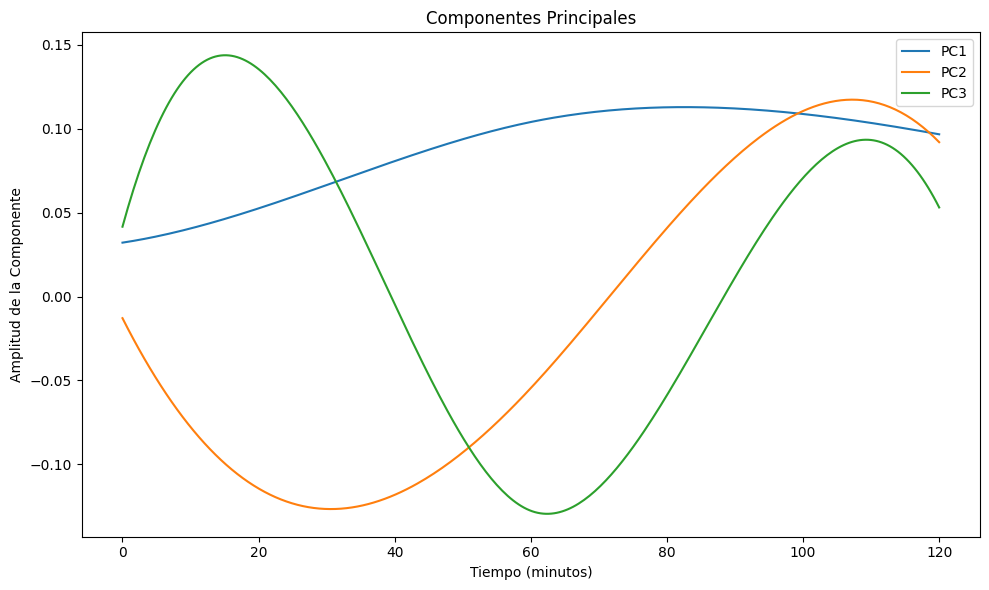

In [47]:
# Asumiendo que components es un FDataGrid obtenido de FPCA
fig, ax = plt.subplots(figsize=(10, 6))  # Un único subplot

for i in range(3):
    # Extraer los valores de y para cada componente principal
    y_values = components[i].data_matrix.squeeze()
    x_values = components.grid_points[0]

    # Comprobemos las dimensiones para asegurarnos de que coinciden
    print(f"Dimensiones de x: {x_values.shape}, Dimensiones de y: {y_values.shape}")

    # Si las dimensiones coinciden, procedemos a graficar
    if x_values.shape == y_values.shape: 
        ax.plot(x_values, y_values, label=f'PC{i+1}')
    else:
        break

ax.set_title('Componentes Principales')
ax.legend()
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Amplitud de la Componente')
plt.tight_layout()
plt.show()


In [48]:
# La variabilidad explicada por cada componente principal
explained_variances = fpca.explained_variance_ratio_
total_variance = explained_variances.sum()
total_variance

0.9915357560376148

### GENERO

### HOMBRE

In [49]:
# Supongamos que 'data_matrix' contiene tus datos de glucosa evaluados en 'tiempos_finos'
fd = FDataGrid(data_matrix=glucosa_hombres, grid_points=tiempos_finos)

# Aplicar FPCA
fpca = FPCA(n_components=3)
fpca.fit(fd)
fd_transformed = fpca.transform(fd)
components = fpca.components_


Dimensiones de x: (300,), Dimensiones de y: (300,)
Dimensiones de x: (300,), Dimensiones de y: (300,)
Dimensiones de x: (300,), Dimensiones de y: (300,)


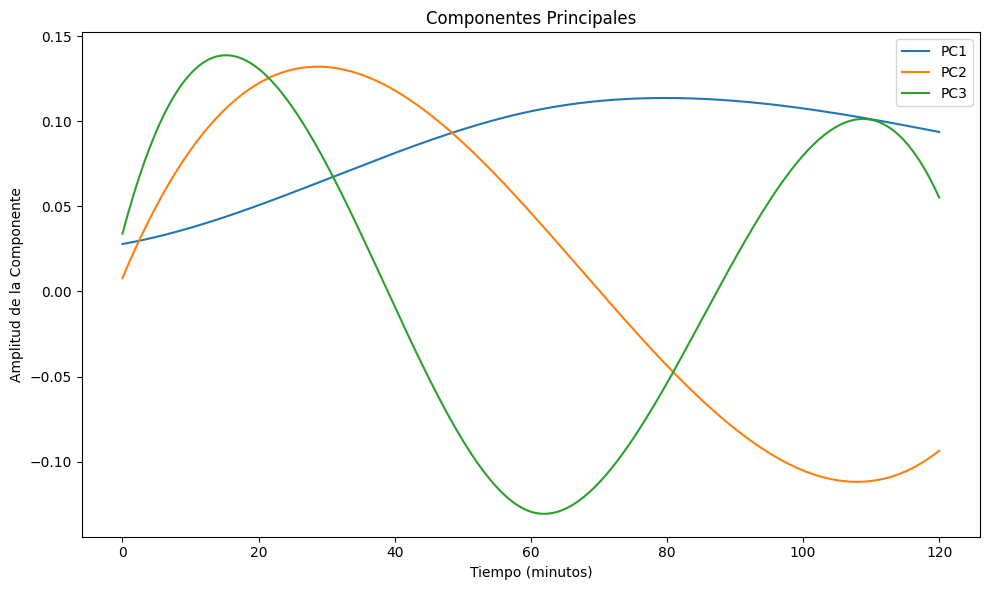

In [50]:
# Asumiendo que components es un FDataGrid obtenido de FPCA
fig, ax = plt.subplots(figsize=(10, 6))  # Un único subplot

for i in range(3):
    # Extraer los valores de y para cada componente principal
    y_values = components[i].data_matrix.squeeze()
    x_values = components.grid_points[0]

    # Comprobemos las dimensiones para asegurarnos de que coinciden
    print(f"Dimensiones de x: {x_values.shape}, Dimensiones de y: {y_values.shape}")

    # Si las dimensiones coinciden, procedemos a graficar
    if x_values.shape == y_values.shape: 
        ax.plot(x_values, y_values, label=f'PC{i+1}')
    else:
        break

ax.set_title('Componentes Principales')
ax.legend()
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Amplitud de la Componente')
plt.tight_layout()
plt.show()


In [51]:
# La variabilidad explicada por cada componente principal
explained_variances = fpca.explained_variance_ratio_
total_variance = explained_variances.sum()
total_variance

0.9918808195188937

### MUJERES

Dimensiones de x: (300,), Dimensiones de y: (300,)
Dimensiones de x: (300,), Dimensiones de y: (300,)
Dimensiones de x: (300,), Dimensiones de y: (300,)


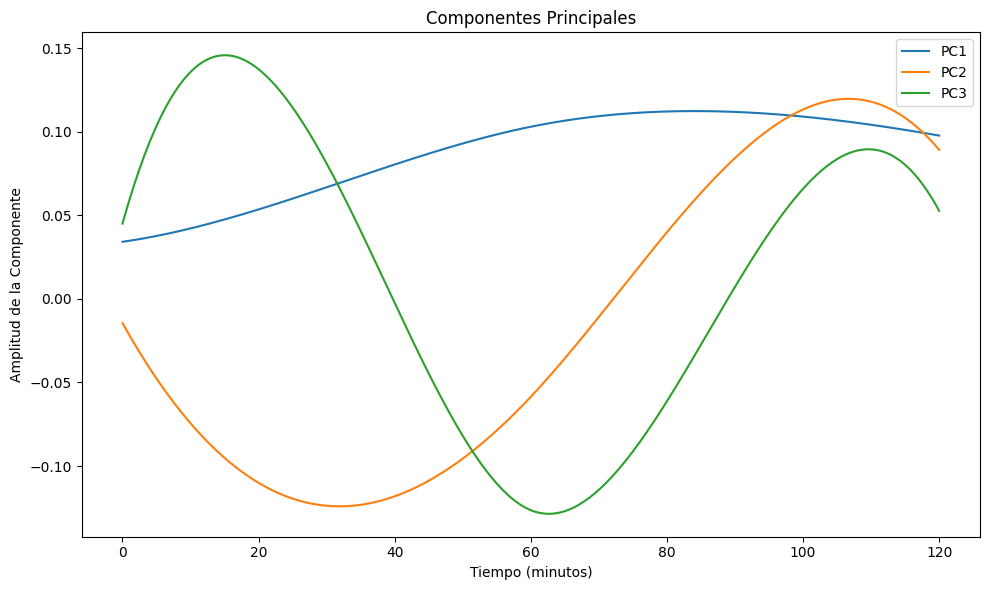

In [52]:
fd = FDataGrid(data_matrix=glucosa_mujeres, grid_points=tiempos_finos)

# Aplicar FPCA
fpca = FPCA(n_components=3)
fpca.fit(fd)
fd_transformed = fpca.transform(fd)
components = fpca.components_

# Asumiendo que components es un FDataGrid obtenido de FPCA
fig, ax = plt.subplots(figsize=(10, 6))  

for i in range(3):
    # Extraer los valores de y para cada componente principal
    y_values = components[i].data_matrix.squeeze()
    x_values = components.grid_points[0]

    # Comprobemos las dimensiones para asegurarnos de que coinciden
    print(f"Dimensiones de x: {x_values.shape}, Dimensiones de y: {y_values.shape}")

    # Si las dimensiones coinciden, procedemos a graficar
    if x_values.shape == y_values.shape: 
        ax.plot(x_values, y_values, label=f'PC{i+1}')
    else:
        break

ax.set_title('Componentes Principales')
ax.legend()
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Amplitud de la Componente')
plt.tight_layout()
plt.show()


In [53]:
# La variabilidad explicada por cada componente principal
explained_variances = fpca.explained_variance_ratio_
total_variance = explained_variances.sum()
total_variance

0.9914990134584554

## KMEANS

In [54]:
from skfda.exploratory.depth import ModifiedBandDepth


In [55]:
# Suponemos que fd_todos ya está definido

# Configuración del K-means
kmeans = KMeans(
    n_clusters=3,
    metric=LpDistance(p=2),
    n_init=10,  
    max_iter=1000, 
    random_state=0,
)

# Ajustar el modelo
kmeans.fit(fd_todos)


KMeans(max_iter=1000, n_clusters=3, n_init=10)

In [56]:
# Obtener las etiquetas de los clusters y los centros
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

Dimensiones de x: (300,), Dimensiones de y: (300,)
Dimensiones de x: (300,), Dimensiones de y: (300,)
Dimensiones de x: (300,), Dimensiones de y: (300,)


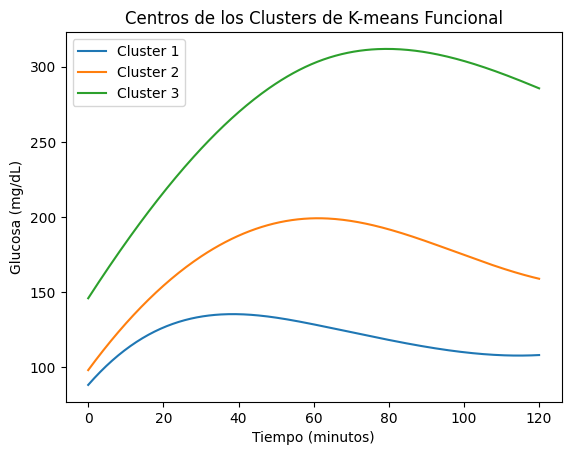

In [59]:
fig, ax = plt.subplots()
for i in range(cluster_centers.n_samples):
    # Asegúrate de que estás extrayendo toda la serie de datos para el centro del cluster
    y_values = cluster_centers[i].data_matrix.squeeze()
    x_values = cluster_centers.grid_points[0]
    
    # Verificar las dimensiones
    print(f"Dimensiones de x: {x_values.shape}, Dimensiones de y: {y_values.shape}")
    
    # Graficar si las dimensiones coinciden
    if x_values.shape == y_values.shape:
        ax.plot(x_values, y_values, label=f'Cluster {i+1}')
    else:
        print(f"Error en las dimensiones para la componente {i+1}")

plt.title('Centros de los Clusters de K-means Funcional')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Glucosa (mg/dL)')
plt.legend()
plt.show()


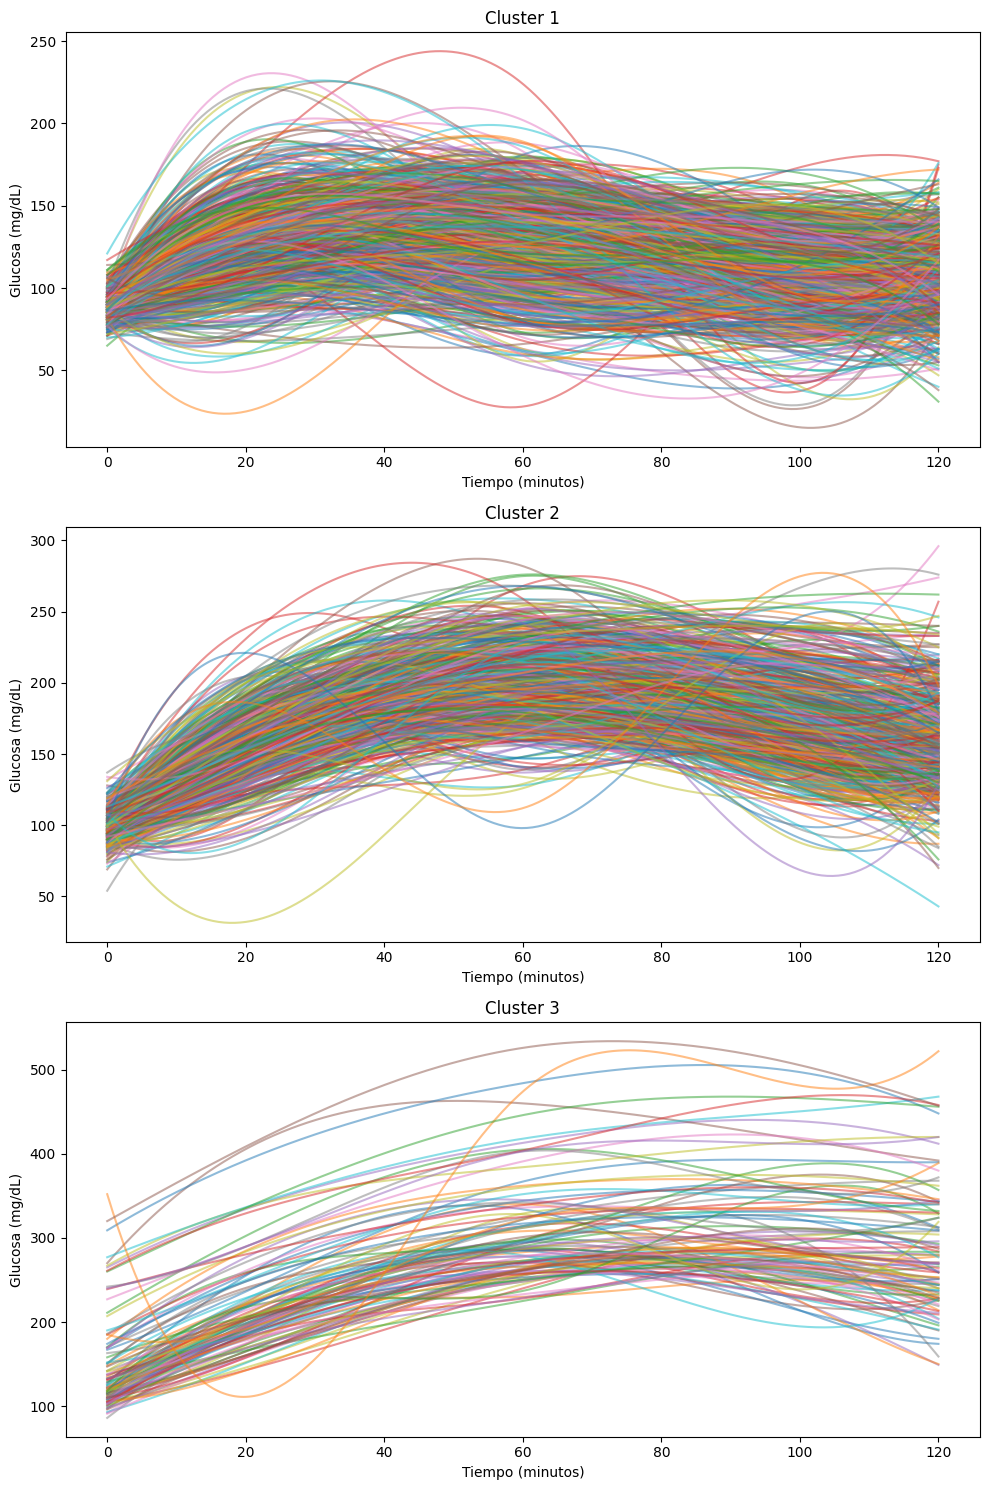

In [60]:
# Configuración de la figura
fig, axes = plt.subplots(nrows=kmeans.n_clusters, ncols=1, figsize=(10, 5 * kmeans.n_clusters))

if kmeans.n_clusters == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    # Filtrar los datos para el cluster actual
    cluster_data = fd_todos.data_matrix[kmeans.labels_ == i]
    
    # Graficar cada curva en el cluster
    for curve in cluster_data:
        ax.plot(fd_todos.grid_points[0], curve.squeeze(), alpha=0.5)  # Use alpha to manage overplotting

    ax.set_title(f'Cluster {i + 1}')
    ax.set_xlabel('Tiempo (minutos)')
    ax.set_ylabel('Glucosa (mg/dL)')

plt.tight_layout()
plt.show()


In [61]:
true_labels = data['CondicionNumerica'].values  # Etiquetas reales numéricas

true_labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

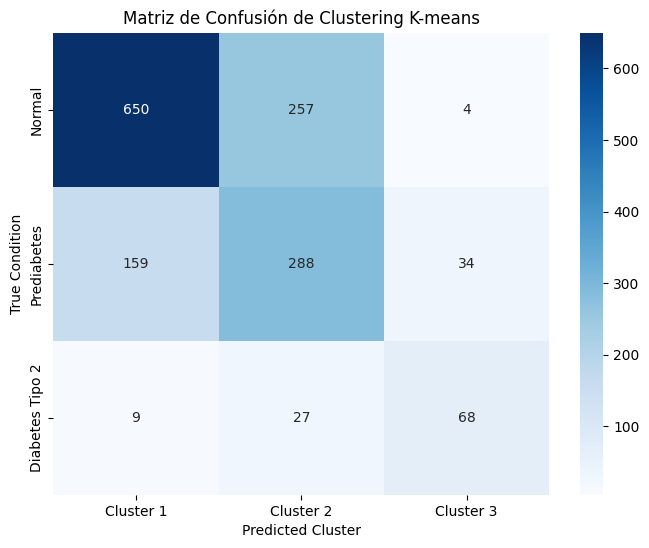

In [62]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
            yticklabels=['Normal', 'Prediabetes', 'Diabetes Tipo 2'])
plt.xlabel('Predicted Cluster')
plt.ylabel('True Condition')
plt.title('Matriz de Confusión de Clustering K-means')
plt.show()

In [63]:
# Calcular la precisión global
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f'Precisión global del clustering: {accuracy * 100:.2f}%')

Precisión global del clustering: 67.25%
